In [13]:
%run ../talktools.py

# MCMC for Bayesian Inference

As we just saw, there are some cases where we can get a closed for the posterior, but many examples we cannot get a closed form. Instead we need to sample the posterior numerically.

o Markov Chain Monte Carlo: Stochastic methods useful for sampling from the target posterior distribution

o Can be implmented where conjugacy does not hold and grid appoximations fail

o Can work in high dimensions

o Iterative: we must decide when convergance has happened

o Some Popular methods: [Metropolis-Hastings](https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm), [NUTS (No U-Turns)](https://arxiv.org/abs/1111.4246), [Hessian-Hamiltonian](https://people.csail.mit.edu/tzumao/h2mc/)...

<u>Idea</u>: Suppose that sampling from the posterior $p(\theta|$**X**) is hard but that we can somehow generate a [Markov chain](http://setosa.io/ev/markov-chains/) $\{\theta(t), t \in T\}$ with stationary distribution $p(\theta|$**X**)

- We want to set up a chain that will take us to the stationary distribution $\pi = p(\theta|$**X**)

- Once we find such a chain, we will start from some initial guess $\theta^0$ and tun the chain for a large number of steps until it converged to $\pi$

- After convergence we run a bunch more steps of the chain and use those as draws from $p(\theta|$**X**).

- All MCMC methods are based on this idea. The differences are in how the Markov chain transitions are created.

<img src="imgs/ma.png">

<img src="imgs/ma1.png">

We can visualize different approaches to sampling [here](https://chi-feng.github.io/mcmc-demo/app.html#AdaptiveMH,standard).

## MCMC with PyMC
https://pymc-devs.github.io/pymc3/

<img width="20%" src="https://docs.pymc.io/_static/pymc3_logo.jpg">

https://docs.pymc.io/examples.html

```
conda install mkl-service -y
pip install pymc3>=3.10.0 arviz 
```

PyMC3 is the most widely used Markov chain Monte Carlo module in Python

- It allows straightforward coding of probability models and posterior sampling of those models with standard (optimized) MCMC algorithms
- Large and complicated (hierarchical) models can be easily coded in PyMC
- Convergence diagnostics and automatic tuning are provided 
- Users can input custom probability distributions and fitting algorithms 
-Great documentation

Let's look at the Presidental approval rating again:

Text(0.5, 1.0, 'Posterior distribution: Biden Approval Feb 2, 2021')

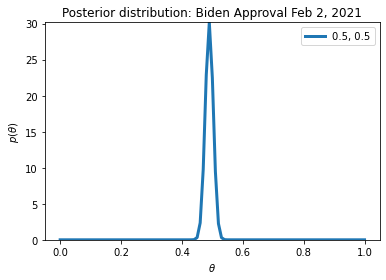

In [22]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

a = 700
n = 1429

alpha = 0.5
beta = 0.5

x_theta = np.linspace(0, 1, 101)
fig, ax = plt.subplots()

p_theta = stats.beta(alpha + a, beta + n - a).pdf(x_theta)
ax.plot(x_theta, p_theta, linewidth=3.,label=f"{alpha}, {beta}")
    
ax.legend()
ax.set_ylim([0, max(p_theta)])
ax.set_xlabel(r"$\theta$")
ax.set_ylabel(r"$p(\theta)$")
ax.set_title("Posterior distribution: Biden Approval Feb 2, 2021")

In [2]:
import pymc3 as pm

with pm.Model() as model:
    theta = pm.Beta('theta', alpha, beta)
    X = pm.Binomial('X', n, theta, observed=a)

WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [15]:
with model:
    step = pm.NUTS()
    trace = pm.sample(20000, step=[step], cores=2, return_inferencedata=False)

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta]
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 20_000 draw iterations (2_000 + 40_000 draws total) took 34 seconds.


In [4]:
pm.sample?

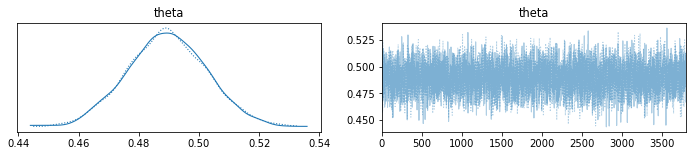

In [16]:
import arviz as az
with model:
    _ = az.plot_trace(trace[1000:][::5])

Note: we started sampling after a burn-in period of a thousand steps. We also "pruned" the result by taking only every 5th step (helps insure some level of independence between samples). 

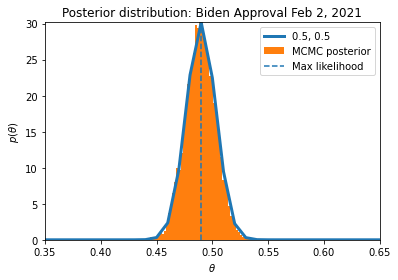

In [23]:
ax.hist(trace['theta'][1000:][::5], bins=50, density=True, label='MCMC posterior')
ax.vlines(x=a / n, ymin=0, ymax=max(p_theta), linestyle='--', label="Max likelihood")
ax.legend()
ax.set_xlim(0.35,0.65)
fig

So our MCMC results agree with the (closed-form) solution for this simple case.

Once we have samples from the posterior we can do cool things:

Suppose we have B samples $\theta_1$...$\theta_B$ from the posterior $p(\theta|$**X**):

1) **Posterior mean**: 
   
The exact equation $E[\theta|$**X**] = $\int \theta p(\theta|$**X**)$d\theta$

Using the sample $E[\theta|$**X**] $\approx \frac{1}{B} \sum_{b=1}^B \theta_b$

In [24]:
trace['theta'][1000:][::5].sum()/len(trace['theta'][1000:][::5])

0.48942789430499883

2) **Marginalization**: 
   
The exact equation $p(\theta_1|$**X**) = $\int p(\theta_1,\theta_2,..\theta_p|$**X**)$d\theta_2\theta_3...\theta_p$

Using the sample $p(\theta_1|$**X**) $\sim \theta_{1,1} ... \theta_{1,B}$

*That is, record the parameter of interest $\theta_1$ from each sample.*

3) **Prediction**: 
   
The exact equation $p(\tilde{X}|$**X**) = $\int p(\tilde{X}|\theta) p(\theta|$**X**)$d\theta$

Using the sample $p(\tilde{X}|$**X**) $\sim \tilde{x_1} | \theta_{1} ... \tilde{x_B} | \theta_{B}$

*That is, take each sample of $\theta$ and determine a value for $x$.*

## Distributions in pymc3

* Continuous - https://docs.pymc.io/api/distributions/continuous.html
* Discrete - https://docs.pymc.io/api/distributions/discrete.html
* Multivariate - https://docs.pymc.io/api/distributions/multivariate.html

For example, if you have a variable which is expected to be Normally distributed, use the `pm.Normal` (Univariate normal log-likelihood).

In [ ]:
pm.Normal?

In [ ]:
pm.Bernoulli?

In [26]:
%load_ext watermark

In [27]:
%watermark --iversions

json      : 2.0.9
arviz     : 0.11.4
pymc3     : 3.11.4
seaborn   : 0.11.2
matplotlib: 3.5.1
autopep8  : 1.6.0
scipy     : 1.8.0
numpy     : 1.20.3

